## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

import cupy as cp
from tomo_encoders import Patches
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
from tomo_encoders.reconstruction.recon import recon_binning, recon_patches_3d, rec_patch, rec_pts
# from tomo_encoders.misc.voxel_processing import cylindrical_mask, normalize_volume_gpu

In [2]:
r_fac = 0.2
ht = 32
wd = 2176
th = 1500
n_sel =int(ht*wd*wd*r_fac/(32**3))

In [3]:
data = cp.random.normal(0,1,(th, ht, wd), dtype = cp.float32)
theta = cp.linspace(0, np.pi, th, dtype = cp.float32)
center = wd/2

In [4]:
vol = np.zeros((ht,wd,wd), dtype = np.uint8)
p_sel = Patches(vol.shape, initialize_by = 'regular-grid', patch_size = (32,32,32), n_points = n_sel)
len(p_sel)*32**3/(ht*wd*wd)

0.19982698961937717

In [5]:
t0 = time.time()
x = np.ones((len(p_sel), 32, 32, 32), dtype = np.uint8)
p_sel.fill_patches_in_volume(x, vol)
print(f"time to make point array: {(time.time()-t0)*1000.0:.2f} ms")

time to make point array: 46.90 ms


In [6]:
vox_coords = np.where(vol == 1) 
pts = cp.asarray(np.asarray(vox_coords), dtype = cp.int32).T # this is already sorted as contiguous array

In [7]:
for i in range(5):
    f = rec_pts(data, theta, center, pts)

TIME rec_pts: 298.55 ms
TIME rec_pts: 279.01 ms
TIME rec_pts: 279.70 ms
TIME rec_pts: 282.27 ms
TIME rec_pts: 279.79 ms


In [8]:
obj = cp.ones((ht,wd,wd), dtype = f.dtype)*f.min()
obj[vox_coords] = f

In [9]:
times = []
for i in range(5):
    obj1, t_ = rec_patch(data, theta, center, 0, wd, 0, wd, 0, ht, TIMEIT=True)
    print(f"time {t_:.2f} ms")
    times.append(t_)
print(f"time = {np.median(times):.2f} ms")    

print(f'Does the reconstruction of points reconcile with the full volume? {~np.any(obj1[vox_coords]-obj[vox_coords])}')

time 1320.09 ms
time 1320.30 ms
time 1322.54 ms
time 1330.20 ms
time 1329.09 ms
time = 1322.54 ms
Does the reconstruction of points reconcile with the full volume? True


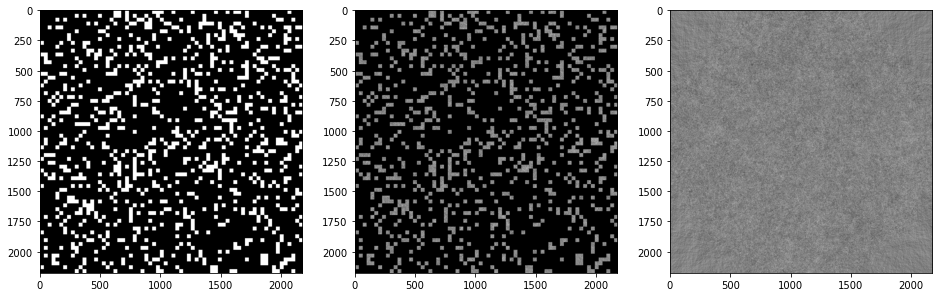

In [10]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
ax[0].imshow(vol[ht//2], cmap = 'gray')
ax[1].imshow(obj.get()[ht//2], cmap = 'gray')
ax[2].imshow(obj1.get()[ht//2], cmap = 'gray')

In [11]:
t0 = time.time()
sub_vols = p_sel.extract(obj.get(), (32,32,32))
t_ext = (time.time()-t0)*1000
print(f'patch extraction time: {t_ext:.2f} ms')

patch extraction time: 207.41 ms
